In [1]:
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         setup_multi_processes, update_data_root)

import wandb

In [2]:
# cfg
cfg = Config.fromfile('../configs/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py')

# epochs
# cfg.runner['max_epochs'] = 100

# img_scale
cfg.img_scale = (3840//5, 2160//5)

# work_dir
cfg.work_dir = '../work_dirs/cascade'

# seed
seed = init_random_seed(42)
set_random_seed(seed, deterministic=True)
cfg.seed = seed

# gpu
cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg.gpu_ids = [0]

# train
cfg.data.train.ann_file = '../data/aihub/train.json'
cfg.data.train.img_prefix = '../data/aihub/'
cfg.data.train.classes = ("선박", "기타부유물", "어망부표") # ("ship", "general float", "fishing net buoy")
cfg.data.train.pipeline[2]['img_scale'] = (2160//5, 3840//5)
cfg.data.train.pipeline[3]['flip_ratio'] = 0.0

# val
cfg.data.val.ann_file = '../data/aihub/valid.json'
cfg.data.val.img_prefix = '../data/aihub/'
cfg.data.val.classes = ("선박", "기타부유물", "어망부표")

# test
cfg.data.test.ann_file = '../data/aihub/train.json'
cfg.data.test.img_prefix = '../data/aihub/'
cfg.data.test.classes = ("선박", "기타부유물", "어망부표")
cfg.data.test.pipeline[1]['img_scale'] = (2160//5, 3840//5)

# cfg.model.bbox_head.num_classes = 3
cfg.model.roi_head.bbox_head[0].num_classes = 3
cfg.model.roi_head.bbox_head[1].num_classes = 3
cfg.model.roi_head.bbox_head[2].num_classes = 3

cfg.data.samples_per_gpu = 32

cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1)
cfg.evaluation = dict(save_best='auto', interval=1, metric='bbox')

cfg.log_config = dict(
    interval=50,
    hooks=[
        dict(type='TextLoggerHook'),
        # dict(type='TensorboardLoggerHook')
        dict(type='WandbLoggerHook', init_kwargs=dict(project='All-SEAing Eye', name='Cascade'))
    ])

# dataset = build_dataset
dataset = build_dataset(cfg.data.train)
# dataset
next(iter(dataset))


loading annotations into memory...
Done (t=2.89s)
creating index...
index created!


{'img_metas': DataContainer({'filename': '../data/aihub/train/images/20201217/0184/PYS_SN_20201217_0184_0018.jpg', 'ori_filename': 'train/images/20201217/0184/PYS_SN_20201217_0184_0018.jpg', 'ori_shape': (2160, 3840, 3), 'img_shape': (432, 768, 3), 'pad_shape': (448, 768, 3), 'scale_factor': array([0.2, 0.2, 0.2, 0.2], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}),
 'img': DataContainer(tensor([[[-0.4226, -0.4226, -0.4226,  ..., -0.7308, -0.7308, -0.7308],
          [-0.4226, -0.4226, -0.4226,  ..., -0.7308, -0.7308, -0.7308],
          [-0.4226, -0.4226, -0.4226,  ..., -0.7137, -0.7308, -0.7308],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
   

860


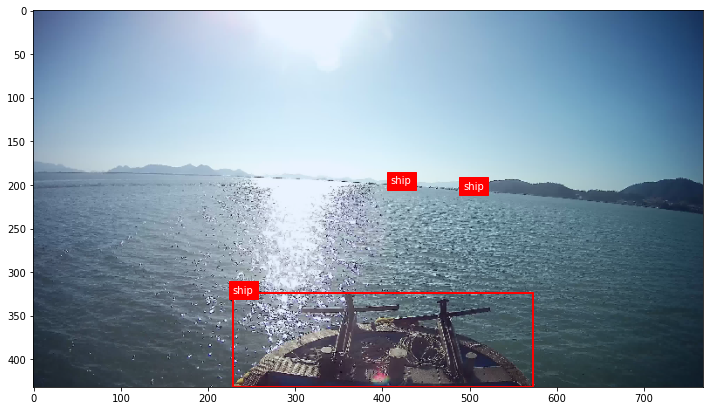

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

i = np.random.randint(0, len(dataset))
print(i)

img = dataset[i]['img'].data.numpy()
min_, max_ = np.min(img), np.max(img)
img = img - (max_+min_)/2
img = img / (max_-min_)
img = img + 0.5
img = np.transpose(img, (1, 2, 0))
img = img[0:cfg.img_scale[1], 0:cfg.img_scale[0]]

classes = ("ship", "general float", "fishing net buoy")

fig, ax = plt.subplots(figsize=(12, 12))

color = ((1,0,0), (0,1,0), (0,0,1))
for (l, t, r, b), clss in zip(dataset[i]['gt_bboxes'].data, dataset[i]['gt_labels'].data):
    rect = mpl.patches.Rectangle((l, t), r-l, b-t, linewidth=2, edgecolor=color[clss], facecolor='none')
    ax.add_patch(rect)
    ax.text(x=l, y=t, s=classes[clss], fontsize=10, color='white', backgroundcolor=color[clss])

plt.imshow(img)
plt.show()

In [4]:
model = build_detector(
    cfg.model,
    train_cfg=cfg.get('train_cfg'),
    test_cfg=cfg.get('test_cfg'))
model.init_weights()

2022-06-11 06:31:15,111 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet101'}
2022-06-11 06:31:15,112 - mmcv - INFO - load model from: torchvision://resnet101
2022-06-11 06:31:15,113 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet101
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


2022-06-11 06:31:17,170 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-06-11 06:31:17,196 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}


2022-06-11 06:31:17,222 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2022-06-11 06:31:17,228 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-06-11 06:31:17,328 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2022-06-11 06:31:17,428 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override'

In [5]:
model.CLASSES = dataset.CLASSES
train_detector(
    model,
    dataset,
    cfg,
    distributed=False,
    validate=True)

2022-06-11 06:31:27,513 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2022-06-11 06:31:28,208 - mmdet - INFO - Start running, host: root@4a37eb830c7b, work_dir: /opt/ml/mmdetection/work_dirs/cascade
2022-06-11 06:31:28,209 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) WandbLoggerHook                    
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook

Done (t=0.21s)
creating index...
index created!


/opt/conda/lib/python3.8/site-packages/mmcv/runner/hooks/evaluation.py:222: UserWarning: runner.meta is None. Creating an empty one.
  warnings.warn('runner.meta is None. Creating an empty one.')
wandb: Currently logged in as: star-bits. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2022-06-11 06:34:20,061 - mmdet - INFO - Epoch [1][50/1307]	lr: 1.978e-03, eta: 14:42:10, time: 3.386, data_time: 0.151, memory: 26135, loss_rpn_cls: 0.5099, loss_rpn_bbox: 0.0834, s0.loss_cls: 0.4701, s0.acc: 85.0269, s0.loss_bbox: 0.0964, s1.loss_cls: 0.1946, s1.acc: 87.2866, s1.loss_bbox: 0.0333, s2.loss_cls: 0.0987, s2.acc: 87.2349, s2.loss_bbox: 0.0055, loss: 1.4918
2022-06-11 06:37:01,575 - mmdet - INFO - Epoch [1][100/1307]	lr: 3.976e-03, eta: 14:19:10, time: 3.230, data_time: 0.038, memory: 26135, loss_rpn_cls: 0.1297, loss_rpn_bbox: 0.0647, s0.loss_cls: 0.2684, s0.acc: 88.9330, s0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 7.9 task/s, elapsed: 672s, ETA:     0s

2022-06-11 07:52:29,198 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=28.79s).
Accumulating evaluation results...


2022-06-11 07:53:01,620 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.345
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=3.17s).


2022-06-11 07:53:03,484 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_1.pth.
2022-06-11 07:53:03,485 - mmdet - INFO - Best bbox_mAP is 0.1920 at 1 epoch.
2022-06-11 07:53:03,493 - mmdet - INFO - Epoch(val) [1][5294]	bbox_mAP: 0.1920, bbox_mAP_50: 0.3450, bbox_mAP_75: 0.1990, bbox_mAP_s: 0.0200, bbox_mAP_m: 0.1250, bbox_mAP_l: 0.2430, bbox_mAP_copypaste: 0.192 0.345 0.199 0.020 0.125 0.243
2022-06-11 07:55:46,629 - mmdet - INFO - Epoch [2][50/1307]	lr: 2.000e-02, eta: 12:40:47, time: 3.262, data_time: 0.152, memory: 26135, loss_rpn_cls: 0.0069, loss_rpn_bbox: 0.0128, s0.loss_cls: 0.0792, s0.acc: 96.7123, s0.loss_bbox: 0.0776, s1.loss_cls: 0.0351, s1.acc: 97.1211, s1.loss_bbox: 0.1092, s2.loss_cls: 0.0219, s2.acc: 96.3572, s2.loss_bbox: 0.0870, loss: 0.4297
2022-06-11 07:58:23,363 - mmdet - INFO - Epoch [2][100/1307]	lr: 2.000e-02, eta: 12:37:41, time: 3.135, data_time: 0.039, memory: 26135, loss_rpn_cls: 0.0067, loss_rpn_bbox: 0.0127, s0.loss_cls: 0.0780, s0.acc: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 7.8 task/s, elapsed: 675s, ETA:     0s

2022-06-11 09:13:03,954 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=29.33s).
Accumulating evaluation results...


2022-06-11 09:13:37,044 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.371
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.176
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=3.28s).


2022-06-11 09:13:37,260 - mmdet - INFO - The previous best checkpoint /opt/ml/mmdetection/work_dirs/cascade/best_bbox_mAP_epoch_1.pth was removed
2022-06-11 09:13:39,006 - mmdet - INFO - Now best checkpoint is saved as best_bbox_mAP_epoch_2.pth.
2022-06-11 09:13:39,007 - mmdet - INFO - Best bbox_mAP is 0.2130 at 2 epoch.
2022-06-11 09:13:39,016 - mmdet - INFO - Epoch(val) [2][5294]	bbox_mAP: 0.2130, bbox_mAP_50: 0.3710, bbox_mAP_75: 0.2140, bbox_mAP_s: 0.0390, bbox_mAP_m: 0.1350, bbox_mAP_l: 0.2870, bbox_mAP_copypaste: 0.213 0.371 0.214 0.039 0.135 0.287
2022-06-11 09:16:22,880 - mmdet - INFO - Epoch [3][50/1307]	lr: 2.000e-02, eta: 11:26:12, time: 3.277, data_time: 0.153, memory: 26135, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0103, s0.loss_cls: 0.0653, s0.acc: 97.2853, s0.loss_bbox: 0.0618, s1.loss_cls: 0.0268, s1.acc: 97.8407, s1.loss_bbox: 0.0920, s2.loss_cls: 0.0168, s2.acc: 97.3091, s2.loss_bbox: 0.0763, loss: 0.3540
2022-06-11 09:19:00,722 - mmdet - INFO - Epoch [3][100/1307]	lr: 

[>>>>>>>>>>>>>>>            ] 2996/5294, 7.9 task/s, elapsed: 380s, ETA:   291s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

2022-06-11 10:36:58,654 - mmdet - INFO - Epoch [4][50/1307]	lr: 2.000e-02, eta: 10:16:00, time: 3.258, data_time: 0.152, memory: 26135, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0085, s0.loss_cls: 0.0555, s0.acc: 97.7114, s0.loss_bbox: 0.0494, s1.loss_cls: 0.0208, s1.acc: 98.3097, s1.loss_bbox: 0.0770, s2.loss_cls: 0.0129, s2.acc: 97.9401, s2.loss_bbox: 0.0674, loss: 0.2949
2022-06-11 10:39:36,305 - mmdet - INFO - Epoch [4][100/1307]	lr: 2.000e-02, eta: 10:13:22, time: 3.153, data_time: 0.038, memory: 26135, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0082, s0.loss_cls: 0.0560, s0.acc: 97.6993, s0.loss_bbox: 0.0503, s1.loss_cls: 0.0211, s1.acc: 98.3080, s1.loss_bbox: 0.0787, s2.los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 5294/5294, 7.9 task/s, elapsed: 671s, ETA:     0s

2022-06-11 11:54:11,108 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=27.56s).
Accumulating evaluation results...


2022-06-11 11:54:42,238 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.381
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=3.12s).


2022-06-11 11:57:25,856 - mmdet - INFO - Epoch [5][50/1307]	lr: 2.000e-02, eta: 9:06:27, time: 3.269, data_time: 0.153, memory: 26135, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0507, s0.acc: 97.9172, s0.loss_bbox: 0.0442, s1.loss_cls: 0.0184, s1.acc: 98.5086, s1.loss_bbox: 0.0695, s2.loss_cls: 0.0111, s2.acc: 98.2754, s2.loss_bbox: 0.0617, loss: 0.2654
2022-06-11 12:00:02,657 - mmdet - INFO - Epoch [5][100/1307]	lr: 2.000e-02, eta: 9:03:48, time: 3.136, data_time: 0.038, memory: 26135, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0077, s0.loss_cls: 0.0526, s0.acc: 97.8350, s0.loss_bbox: 0.0463, s1.loss_cls: 0.0188, s1.acc: 98.4912, s1.loss_bbox: 0.0725, s2.loss_cls: 0.0113, s2.acc: 98.2144, s2.loss_bbox: 0.0644, loss: 0.2765
2022-06-11 12:02:39,969 - mmdet - INFO - Epoch [5][150/1307]	lr: 2.000e-02, eta: 9:01:10, time: 3.146, data_time: 0.039, memory: 26135, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0075, s0.loss_cls: 0.0510, s0.acc: 97.9111, s0.loss_bbox: 0.0449, s1.loss_cls:

[>>>>>>>>>>>>>>>>>>>>>>>>>  ] 4982/5294, 7.9 task/s, elapsed: 633s, ETA:    40s

2022-06-11 13:17:52,987 - mmdet - INFO - Epoch [6][50/1307]	lr: 2.000e-02, eta: 7:57:19, time: 3.257, data_time: 0.153, memory: 26135, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0068, s0.loss_cls: 0.0481, s0.acc: 98.0282, s0.loss_bbox: 0.0406, s1.loss_cls: 0.0162, s1.acc: 98.7019, s1.loss_bbox: 0.0653, s2.loss_cls: 0.0098, s2.acc: 98.4597, s2.loss_bbox: 0.0594, loss: 0.2488
2022-06-11 13:20:29,648 - mmdet - INFO - Epoch [6][100/1307]	lr: 2.000e-02, eta: 7:54:41, time: 3.133, data_time: 0.038, memory: 26135, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0071, s0.loss_cls: 0.0490, s0.acc: 97.9965, s0.loss_bbox: 0.0413, s1.loss_cls: 0.0171, s1.acc: 98.6295, s1.loss_bbox: 0.0648, s2.loss_cls: 0.0102, s2.acc: 98.4134, s2.loss_bbox: 0.0580, loss: 0.2503
2022-06-11 13:23:06,323 - mmdet - INFO - Epoch [6][150/1307]	lr: 2.000e-02, eta: 7:52:03, time: 3.133, data_time: 0.039, memory: 26135, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0069, s0.loss_cls: 0.0483, s0.acc: 98.0294, s0.loss_bbox: 0.0412, s1.loss_cls:

KeyboardInterrupt: 